### Classification of FR abstracts as big data or not.

Uses Doc2Vec as vectorization and initial labeled dataset of 1200 abstracts.

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 50)

#### Ingest Data - labeled set and full corpus

In [2]:
# read in new training dataset - 1600 labeled abstracts
df_lab = pd.read_csv("../../../../data/prd/Digital_abstract_labelled/AUG-2022-labelled_abstracts.csv")
print(df_lab.shape)
df_lab.head()

(1200, 8)


,Unnamed: 0,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [3]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [4]:
#data frame with all of the abstracts
df = pd.read_pickle("../../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

# Reset the df index and create a variable index to link with PROJECT_ID
df.reset_index(inplace = True, drop = True)
print(df.shape)
df.head()

(1143869, 30)


,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
df = df[['PROJECT_ID','ABSTRACT']]
df.head()

,PROJECT_ID,ABSTRACT
0,89996,"This is a project to explore Game-based, Metap..."
1,89997,Institution: Franklin Institute Science Museum...
2,89998,Through programs (including small group conver...
3,89999,In partnership with the American Chemical Soci...
4,90001,The Center for Molecular Interfacing (CMI) wil...


In [6]:
# merge with the labelled data using PROJECT_ID.
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
df_merge = df.merge(df_lab[['PROJECT_ID','Is it related to Big-Data','label']], how='left', on='PROJECT_ID')
len(df_merge)

1143869

In [7]:
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN
2,89998,Through programs (including small group conver...,NaN,NaN
3,89999,In partnership with the American Chemical Soci...,NaN,NaN
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN


In [8]:
# Save project ID of labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Get the index of labelled abstract
subset_df = df_merge.loc[df_merge['PROJECT_ID'].isin(project_id_lab),['PROJECT_ID','label']]

In [9]:
subset_df.head()

,PROJECT_ID,label
1050,91187,Non Big-data
1413,91311,Non Big-data
3557,93680,Big-data
4845,95339,Non Big-data
6670,97249,Non Big-data


In [10]:
# build training and testing sets from the labeled data 
# sklearn to find list of indices for training and test set

X_train_idx, X_test_idx, y_train_doc2vec, y_test_doc2vec = train_test_split(subset_df.index, 
                                                                        subset_df['label'].values, 
                                                                        test_size=0.20, random_state=0, 
                                                                        stratify=subset_df['label'].values)


# 1. Doc2Vec approach

## 1.1. Vectorize, build the training and test sample

In [9]:
# tagging and saving data (do not need to run this again - data is saved in tagged_df.csv)

#tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['ABSTRACT'])]
#tagged_df = pd.DataFrame(tagged_data)
#tagged_df.to_csv('tagged_df.csv')

In [12]:
# Create the Doc2Vec model and train using labelled data (do not need to run this again - model saved in d2v.model)

#model = gensim.models.doc2vec.Doc2Vec(vector_size=100, epochs=100) #min_count=2 - min number of times it shows up
#model.build_vocab(tagged_data)
#model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
#model.save("d2v.model")

In [11]:
# Load the Doc2Vec model
model = Doc2Vec.load("../../../../data/prd/Doc2Vec/d2v.model")

In [12]:
# Get document representations from the model results - list of lists.  
vector = []
for i in range(0, len(df)):
    vectorthis = (model.dv[i]).tolist()
    vector.append(vectorthis)

In [13]:
# doc representations - each row is a document representation
doc_reps = pd.DataFrame(vector)
print(doc_reps.shape)
doc_reps.head()

(1143869, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.982922,2.319988,3.742522,0.944506,-1.694736,-3.728322,0.204749,-1.112957,1.098760,-4.612341,0.733703,-2.214583,-0.259219,-0.214456,0.995408,-1.186774,-0.131439,-1.180803,1.841610,-1.639843,-2.358011,3.413001,3.731894,1.390462,3.263571,...,-1.041995,2.063597,0.650890,-0.009327,-2.202883,-0.411864,-1.595071,-1.730732,-1.397346,-0.712966,1.295766,-1.123551,-0.102224,2.066787,0.765735,4.270835,3.079768,-0.978548,0.275256,0.677612,-2.733896,0.354953,-1.033716,0.140886,-2.464530
1,0.456848,-0.227907,-0.991774,2.260244,-1.303596,-1.987082,-2.183362,1.811930,-0.897663,0.843100,0.932140,-4.361772,-0.521623,0.296213,1.349446,-0.805430,-1.736138,-0.538803,0.459269,-0.474585,-2.454310,1.329033,2.992836,1.203448,0.310803,...,1.549266,-1.570076,-1.332427,-0.770249,1.699491,-0.274130,-5.603177,-1.300055,-0.810193,-2.107439,0.174144,2.185729,-2.083795,2.886135,-0.271330,3.001608,2.179992,3.509960,0.711321,-0.808178,-1.946631,-0.329511,-1.518070,1.803749,-0.085112
2,3.939317,-0.077519,1.721057,-0.717855,-3.445618,-2.466907,-0.437651,3.141626,-3.202489,0.375526,0.532302,-1.165914,-0.406458,0.446012,-1.526703,-0.200713,1.268217,0.085013,-0.847399,0.953084,0.618521,2.339281,-1.306460,0.514830,2.718282,...,0.788696,1.818320,-1.556971,1.819863,1.508475,-1.179790,0.828222,0.005567,-0.094424,-0.004659,-0.880713,-0.720786,1.472627,-1.323683,3.885650,1.376774,-0.988943,0.242667,-1.518137,-0.670374,-1.113849,-0.119800,-4.312647,-0.575666,-0.374445
3,0.261933,2.833923,-1.429265,2.710543,-2.051509,-2.664451,1.328356,0.693114,-2.763685,1.123290,-1.326368,-1.178106,2.254581,2.241744,0.068839,1.155099,1.886543,-2.059903,-1.559700,-0.770142,-0.253473,-0.482159,0.112768,-0.993233,-0.440269,...,-0.095776,0.772124,-0.252873,-0.083401,-1.206205,-0.901444,1.999393,0.931728,-1.386474,-1.996466,-2.597653,-1.525401,-1.121509,0.461437,-0.235091,2.322187,-1.351750,0.528141,-2.293975,-0.394241,-1.240165,0.156464,-0.477509,0.817239,0.814438
4,1.591960,1.018378,-0.159254,1.763578,-1.124414,-0.417599,-1.689906,0.896199,-0.812358,-0.964306,-1.619780,0.353326,2.982134,1.652212,0.084070,-2.297758,-0.385808,-2.790571,2.477949,0.223171,0.887371,1.535304,0.736297,-0.550977,3.002540,...,-0.894851,2.199989,-2.327350,0.552252,0.862642,-0.526882,2.033086,0.602459,0.172678,-1.177264,-2.423429,1.038152,-1.498387,-1.542013,0.237539,-2.691047,-1.320943,1.387134,1.664728,-0.789113,-0.246745,2.204133,-1.852782,-2.572883,2.798885


In [14]:
# convert to numpy array
doc_reps_np = doc_reps.to_numpy()

In [15]:
# Create feature train and test sets from the Doc2Vec matrix

X_train_doc2vec = doc_reps_np[X_train_idx] 
X_test_doc2vec = doc_reps_np[X_test_idx]

## 1.2. KNN classifier

In [16]:
# number of neighbors
k = int(math.sqrt(len(y_train_doc2vec)))
print('Number of neighbors:', k)

Number of neighbors: 30


In [17]:
# Run KNN

classifierKNN = KNeighborsClassifier(n_neighbors= k)  # njobs? don't need

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifierKNN, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifierKNN.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifierKNN.score(X_test_doc2vec,y_test_doc2vec)

[0.75       0.734375   0.74479167 0.77083333 0.77083333]
Accuracy: 0.75.   Standard Deviation: 0.01


0.7458333333333333

In [18]:
# Predict the classification
y_pred_doc2vec = classifierKNN.predict(X_test_doc2vec)

In [19]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 48  49]
 [ 12 131]]
              precision    recall  f1-score   support

    Big-data       0.80      0.49      0.61        97
Non Big-data       0.73      0.92      0.81       143

    accuracy                           0.75       240
   macro avg       0.76      0.71      0.71       240
weighted avg       0.76      0.75      0.73       240



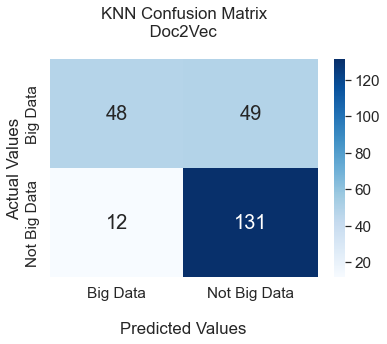

In [20]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('KNN Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_KNN.png', bbox_inches='tight')
plt.show()

In [21]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifierKNN.predict(vector)
t2 = time.time()

print(t2-t1)

173.55302381515503


In [22]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_KNN'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data


## 1.3. SVM

In [23]:
# We run SVM with default parameters provides by Sklearn. We train the model

classifier_svm = svm.SVC()

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_svm, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_svm.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_svm.score(X_test_doc2vec,y_test_doc2vec)

[0.84375    0.765625   0.81770833 0.8125     0.80208333]
Accuracy: 0.81.   Standard Deviation: 0.03


0.8208333333333333

In [24]:
# Predict the classification
y_pred_doc2vec = classifier_svm.predict(X_test_doc2vec)

In [25]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 76  21]
 [ 22 121]]
              precision    recall  f1-score   support

    Big-data       0.78      0.78      0.78        97
Non Big-data       0.85      0.85      0.85       143

    accuracy                           0.82       240
   macro avg       0.81      0.81      0.81       240
weighted avg       0.82      0.82      0.82       240



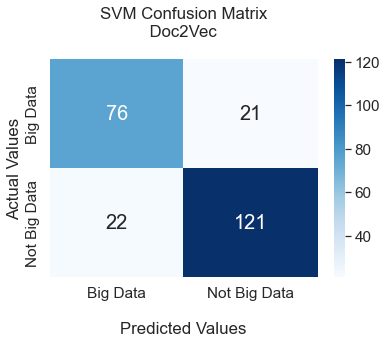

In [26]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('SVM Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_SVM.png', bbox_inches='tight')
plt.show()

In [27]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_svm.predict(vector)
t2 = time.time()

print(t2-t1)

98.24922800064087


In [28]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_SVM'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data


## 1.4. Decision Tree

In [29]:
# Use default parameters provides by SKLearn and train the model
classifier_DT = DecisionTreeClassifier(random_state = 0)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_DT, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_DT.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_DT.score(X_test_doc2vec,y_test_doc2vec)

[0.63541667 0.57291667 0.64583333 0.64583333 0.6875    ]
Accuracy: 0.64.   Standard Deviation: 0.04


0.6708333333333333

In [30]:
# Predict the classification
y_pred_doc2vec = classifier_DT.predict(X_test_doc2vec)

In [31]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 60  37]
 [ 42 101]]
              precision    recall  f1-score   support

    Big-data       0.59      0.62      0.60        97
Non Big-data       0.73      0.71      0.72       143

    accuracy                           0.67       240
   macro avg       0.66      0.66      0.66       240
weighted avg       0.67      0.67      0.67       240



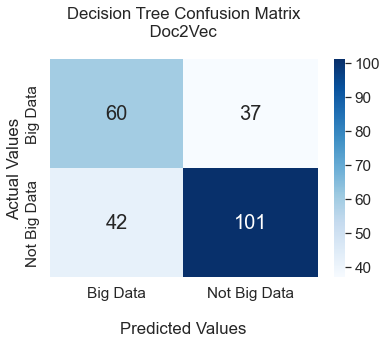

In [32]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Decision Tree Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_DT.png', bbox_inches='tight')
plt.show()

In [33]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_DT.predict(vector)
t2 = time.time()

print(t2-t1)

6.054344177246094


In [34]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_DT'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data


## 1.5. Random Forest

In [35]:
# Use default parameters provides by SKLearn and train the model
classifier_RF = RandomForestClassifier(random_state=0)  # use njobs?

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_RF, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_RF.fit(X_train_doc2vec, y_train_doc2vec)

# find model accuracy
classifier_RF.score(X_test_doc2vec,y_test_doc2vec)

[0.8125     0.76041667 0.796875   0.79166667 0.78645833]
Accuracy: 0.79.   Standard Deviation: 0.02


0.775

In [36]:
# Predict the classification
y_pred_doc2vec = classifier_RF.predict(X_test_doc2vec)

In [37]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 56  41]
 [ 13 130]]
              precision    recall  f1-score   support

    Big-data       0.81      0.58      0.67        97
Non Big-data       0.76      0.91      0.83       143

    accuracy                           0.78       240
   macro avg       0.79      0.74      0.75       240
weighted avg       0.78      0.78      0.77       240



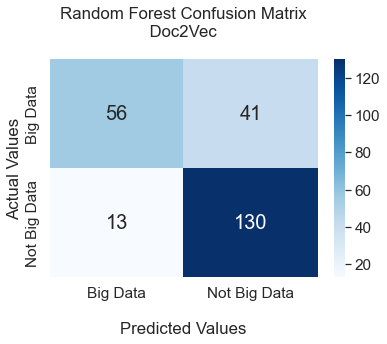

In [38]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Random Forest Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_RF.png', bbox_inches='tight')
plt.show()

In [39]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_RF.predict(vector)
t2 = time.time()

print(t2-t1)

15.182868003845215


In [40]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_RF'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data


## 1.6. Neural network classifier

In [41]:
# Use default parameters provides by SKLearn and train the model
classifier_nn = MLPClassifier(random_state=0, verbose=True)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_nn, X_train_doc2vec, y_train_doc2vec, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
t1 = time.time()
classifier_nn.fit(X_train_doc2vec, y_train_doc2vec)
t2 = time.time()

print(t2-t1)

# find model accuracy
classifier_nn.score(X_test_doc2vec,y_test_doc2vec)

Iteration 1, loss = 0.79243276
Iteration 2, loss = 0.64794194
Iteration 3, loss = 0.55791869
Iteration 4, loss = 0.48840315
Iteration 5, loss = 0.44609310
Iteration 6, loss = 0.40993627
Iteration 7, loss = 0.38469202
Iteration 8, loss = 0.36560971
Iteration 9, loss = 0.34570157
Iteration 10, loss = 0.32979282
Iteration 11, loss = 0.31517435
Iteration 12, loss = 0.30102682
Iteration 13, loss = 0.28969028
Iteration 14, loss = 0.27798590
Iteration 15, loss = 0.26692998
Iteration 16, loss = 0.25735027
Iteration 17, loss = 0.24818304
Iteration 18, loss = 0.23885870
Iteration 19, loss = 0.23062049
Iteration 20, loss = 0.22197090
Iteration 21, loss = 0.21464932
Iteration 22, loss = 0.20692034
Iteration 23, loss = 0.19922450
Iteration 24, loss = 0.19183275
Iteration 25, loss = 0.18476420
Iteration 26, loss = 0.17817129
Iteration 27, loss = 0.17148300
Iteration 28, loss = 0.16556190
Iteration 29, loss = 0.15905895
Iteration 30, loss = 0.15333712
Iteration 31, loss = 0.14745868
Iteration 32, los

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.21590205
Iteration 20, loss = 0.20747463
Iteration 21, loss = 0.20030182
Iteration 22, loss = 0.19252845
Iteration 23, loss = 0.18525896
Iteration 24, loss = 0.17876147
Iteration 25, loss = 0.17162275
Iteration 26, loss = 0.16521200
Iteration 27, loss = 0.15898600
Iteration 28, loss = 0.15324764
Iteration 29, loss = 0.14712362
Iteration 30, loss = 0.14142349
Iteration 31, loss = 0.13585110
Iteration 32, loss = 0.13042222
Iteration 33, loss = 0.12548074
Iteration 34, loss = 0.12062016
Iteration 35, loss = 0.11562092
Iteration 36, loss = 0.11111211
Iteration 37, loss = 0.10667301
Iteration 38, loss = 0.10271006
Iteration 39, loss = 0.09836735
Iteration 40, loss = 0.09469737
Iteration 41, loss = 0.09070650
Iteration 42, loss = 0.08721591
Iteration 43, loss = 0.08381841
Iteration 44, loss = 0.08051273
Iteration 45, loss = 0.07735156
Iteration 46, loss = 0.07433038
Iteration 47, loss = 0.07126909
Iteration 48, loss = 0.06862617
Iteration 49, loss = 0.06614051
Iteratio

/apps/software/standard/core/anaconda/2020.11-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.7958333333333333

In [42]:
# Predict the classification
y_pred_doc2vec = classifier_nn.predict(X_test_doc2vec)

In [43]:
# Classifier performance
confusion = confusion_matrix(y_test_doc2vec, y_pred_doc2vec)
print(confusion)
print(classification_report(y_test_doc2vec, y_pred_doc2vec))

[[ 72  25]
 [ 24 119]]
              precision    recall  f1-score   support

    Big-data       0.75      0.74      0.75        97
Non Big-data       0.83      0.83      0.83       143

    accuracy                           0.80       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.80      0.80      0.80       240



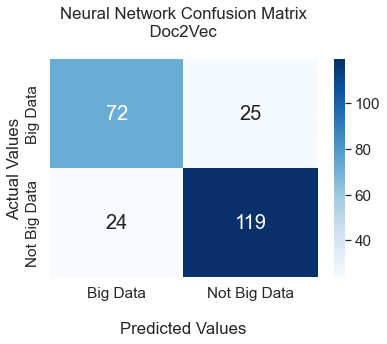

In [44]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Neural Network Confusion Matrix\n Doc2Vec \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/doc2vec_NN.png', bbox_inches='tight')
plt.show()

In [45]:
# Predict the classification for the whole data
t1 = time.time()
y_doc2vec = classifier_nn.predict(vector)
t2 = time.time()

print(t2-t1)

6.784210920333862


In [46]:
# The vector keeps the order from index. Just add the prediction as new variable
df_merge['Prediction_NN'] = y_doc2vec
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data


In [47]:
# save classification results
df_merge.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/big_data/doc2vec_old_training_set.csv")